# Gesture Recognition Project
This project involves building a 3D Convolutional Neural Network (CNN) to correctly recognize hand gestures by a user to control a smart TV.

The objective of this projects is to build a hand gesture recognition model that can be hosted on a camera installed in a smart TV that can understand 5 gestures. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
-	Thumbs up:  Increase the volume
-	Thumbs down: Decrease the volume
-	Left swipe: 'Jump' backwards 10 seconds
-	Right swipe: 'Jump' forward 10 seconds  
-	Stop: Pause the movie


#### Contributors : LakshmiKanth, Sowmily Dutta

In [1]:
# This script sets up the necessary imports for a wide range of tasks,
# including file handling, data manipulation, image processing, and deep learning.
# It provides the foundational tools to work with structured data, process images,
# and design, train, and optimize deep learning models effectively.

import pathlib
import random as rn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Input, Dense, LSTM, GRU, Flatten, TimeDistributed, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D, Reshape  # Correct import
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet
from PIL import Image, ImageEnhance, ImageFilter
import cv2

import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [2]:
# This code sets seeds for reproducibility in random number generation across NumPy, Python's random module, 
# and TensorFlow. Ensuring reproducibility is essential when developing and training machine learning models.

np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
# This code defines file paths for train and validation datasets in CSV format.
# It then reads these files using pandas, shuffles the data for randomness, and converts them into numpy arrays for further processing.

# Defining the train and val CSV files
train_csv_path = "/home/datasets/Project_data/train.csv"
val_csv_path = "/home/datasets/Project_data/val.csv"

# Read and shuffle CSV files using pandas
train_doc = pd.read_csv(train_csv_path, sep=";", header=None).sample(frac=1, random_state=30).values
val_doc = pd.read_csv(val_csv_path, sep=";", header=None).sample(frac=1, random_state=30).values

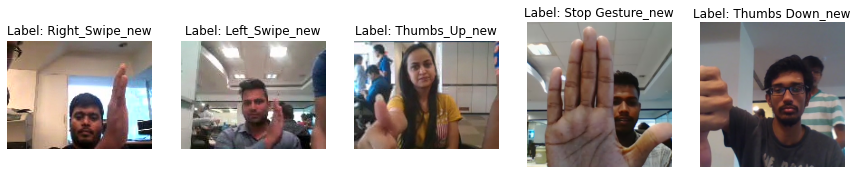

In [4]:
# High-level overview:
# The code snippet is designed to visualize a sample of images from a training dataset.
# It randomly selects 5 images, loads them, and displays them in a grid along with their corresponding labels.
# This is a common practice for exploratory data analysis to get a visual understanding of the data.

# Define train dataset path
train_data_path = pathlib.Path("/home/datasets/Project_data/train")

# Generate 5 random indices
random_indices = rn.sample(range(len(train_doc)), 5)

# Plot 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image_path = list(train_data_path.glob(f"{train_doc[idx, 0]}/*.png"))[0]
    image = plt.imread(str(image_path))
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {train_doc[idx, 1]}")

plt.show()

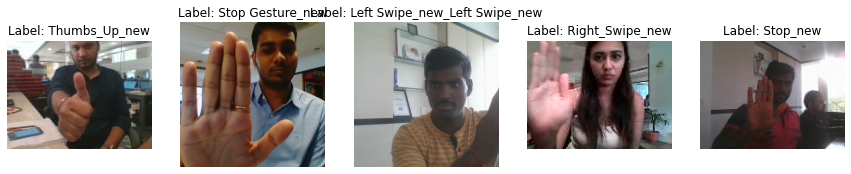

In [5]:
# High-level overview:
# This code snippet mirrors the previous one, but it's designed to visualize a sample of images from the validation dataset.
# It randomly selects 5 images from the validation set, loads them, and displays them in a grid, along with their associated labels.
# This helps in visually inspecting the validation data and ensuring its quality and representativeness.

# Define val dataset path
val_data_path = pathlib.Path("/home/datasets/Project_data/val")

# Generate 5 random indices
random_indices = rn.sample(range(len(val_doc)), 5)

# Plot 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image_path = list(val_data_path.glob(f"{val_doc[idx, 0]}/*.png"))[0]
    image = plt.imread(str(image_path))
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {val_doc[idx, 1]}")

plt.show()

In [6]:
# High-level overview:
# This code snippet prints the shape of the training and validation data.
# The shape typically represents the number of samples and features (or dimensions) in each dataset.
# This is a fundamental step in data exploration to understand the size and structure of the data.

print(f'Shape of training data: {train_doc.shape}')
print(f'Shape of validation data: {val_doc.shape}')

Shape of training data: (663, 3)
Shape of validation data: (100, 3)


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
# High-level overview:
# This code defines a data generator function for 3D Convolutional Neural Networks (Conv3D).
# It's designed to read video data from a specified source, preprocess it by resizing and normalizing frames,
# and then yield batches of video data and their corresponding labels.
# The generator handles batching, shuffling, and ensures that frame indices are valid, making it suitable for training a Conv3D model.

def generator(source_path, folder_list, batch_size, x=30, y=120, z=120, k=30):
    """Data generator for Conv3D models."""

    img_idx = np.linspace(0, 29, k, dtype=int)  # Frame indices to sample
    num_batches = len(folder_list) // batch_size  # Number of full batches

    def yield_part(btch_size, folder_subset):
        batch_data = np.zeros((btch_size, x, y, z, 3))  # Video data
        batch_labels = np.zeros((btch_size,), dtype=int)

        for folder_idx in range(btch_size):
            video_folder, _, label = folder_subset[folder_idx]  # Unpack tuple/list
            label = int(label)  # Ensure label is an integer

            video_path = os.path.join(source_path, video_folder)
            imgs = sorted(os.listdir(video_path))

            # Ensure we don't exceed available frames
            max_frames = len(imgs)
            selected_frames = [i for i in img_idx if i < max_frames]  # Only valid indices

            for idx, item in enumerate(selected_frames):
                img_path = os.path.join(video_path, imgs[item])
                image = imread(img_path).astype(np.float32) / 255.0  # Normalize
                image = resize(image, (y, z))  # Resize

                batch_data[folder_idx, idx, :, :, :] = image  # Assign to batch

            batch_labels[folder_idx] = label

        yield batch_data, batch_labels

    while True:
        np.random.shuffle(folder_list)  # Shuffle dataset for each epoch

        for batch in range(num_batches):
            batch_subset = folder_list[batch * batch_size : (batch + 1) * batch_size]
            yield from yield_part(batch_size, batch_subset)

        remaining = len(folder_list) % batch_size  # Handle leftover data
        if remaining > 0:
            batch_subset = folder_list[-remaining:]  # Last few samples
            yield from yield_part(remaining, batch_subset)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
# High-level overview:
# This code snippet sets up and prints key training parameters.
# It assigns the training and validation data paths, calculates and prints the number of training and validation sequences,
# defines and prints the number of epochs and the batch size.
# Essentially, it's a configuration section that displays the important settings for the training process.

train_path = train_data_path
val_path = val_data_path
num_train_sequences = len(train_doc)
print("-"*100)
print('No of training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('No of validation sequences =', num_val_sequences)
num_epochs = 20
print ('No of Epochs =', num_epochs)
batch_size = 20
print ('Batch Size =', batch_size)
print("-"*100)

----------------------------------------------------------------------------------------------------
No of training sequences = 663
No of validation sequences = 100
No of Epochs = 20
Batch Size = 20
----------------------------------------------------------------------------------------------------


In [9]:
val_files = os.listdir(val_path)
print(f"Validation directory contains {len(val_files)} items.")

Validation directory contains 100 items.


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam. Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train. Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`. The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make. Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [10]:
# High-level overview:
# This function prepares the training environment before model fitting.
# It sets up data generators for training and validation, configures model checkpoints, and optionally adds callbacks for learning rate reduction and early stopping.
# It also calculates the steps per epoch and validation steps based on the dataset size and batch size.
# Essentially, it's a setup routine that handles data loading, callback creation, and step calculations for the training process.

def before_model_fitting(enable_lr_reduction=False, lr_factor=0.5, lr_patience=3, min_lr=1e-6,
                         enable_early_stopping=False, es_patience=5, es_monitor='val_loss', frames_to_sample=30):

    train_folder_list = train_doc.tolist()
    val_folder_list = val_doc.tolist()

    train_generator = generator(train_path, train_folder_list, batch_size, k=frames_to_sample)
    val_generator = generator(val_path, val_folder_list, batch_size, k=frames_to_sample)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto'
                                 #save_freq='epoch'
                                )

    # Initialize callbacks list
    callbacks_list = [checkpoint]

    # Add ReduceLROnPlateau if enabled
    if enable_lr_reduction:
        LR = ReduceLROnPlateau(monitor='val_loss',
                               factor=lr_factor,
                               patience=lr_patience,
                               verbose=1,
                               min_lr=min_lr)
        callbacks_list.append(LR)

    # Add EarlyStopping if enabled
    if enable_early_stopping:
        early_stopping = EarlyStopping(monitor=es_monitor,
                                       patience=es_patience,
                                       restore_best_weights=True,
                                       verbose=1)
        callbacks_list.append(early_stopping)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint

In [11]:
# High-level overview:
# This function generates and displays plots of the training and validation loss and accuracy over epochs.
# It takes the training history object as input, which contains the metrics recorded during training.
# The function creates two subplots: one for loss and one for accuracy, showing the trends for both training and validation sets.
# This visual representation helps in analyzing the model's performance and identifying issues like overfitting or underfitting.

def plot_accuracy_loss_graph(history):
        plt.figure(figsize=(20,6))
        ax1 = plt.subplot(121)
        ax1 = plt.plot(history.history['loss'])
        ax1 = plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend(['Train', 'Validation'], loc='lower left')
        ax2 = plt.subplot(122)
        ax2 = plt.plot(history.history['sparse_categorical_accuracy'])
        ax2 = plt.plot(history.history['val_sparse_categorical_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('sparse_categorical_accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='lower left')

#### MODEL 1 >>> Conv 3D Model

- Input image size 120X120
- Number of Epochs: 20
- Batch Size: 20
- RMSprop optimiser with learning rate 0.0010 with Learning Rate Reduction (lr_factor=0.3, lr_patience=3, min_lr=1e-6)
- Used Dropouts
- 30/30 frames as input
- Total params: 11,396,613
- Trainable params: 11,396,613
- Non-trainable params: 0

In [12]:
# High-level overview:
# This code defines and trains a 3D Convolutional Neural Network (Conv3D) model for video classification.
# It starts by defining the model architecture using the Sequential API, including Conv3D layers, MaxPooling3D, Dropout, and Dense layers.
# The model is then compiled with the RMSprop optimizer and sparse categorical cross-entropy loss.
# The 'before_model_fitting' function is called to set up data generators, callbacks for learning rate reduction, and calculate steps per epoch.
# Finally, the model is trained using the 'fit' method with the generated data and callbacks.
# The summary of the model is printed to show the architecture and parameters.

input_shape = (30, 120, 120, 3)

model_sample = Sequential([

        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D(pool_size=(2,2,2)),
        Conv3D(64,kernel_size=(3,3,3),activation='relu'),
        MaxPooling3D(pool_size=(2,2,2)),
        Conv3D(128,kernel_size=(3,3,3),activation='relu'),
        MaxPooling3D(pool_size=(2,2,2)),
        Dropout(0.5),

        Flatten(),
        Dense(256,activation='relu'),
        Dropout(0.25),

        Dense(128,activation='relu'),
        Dropout(0.25),

        Dense(64,activation='relu'),
        Dropout(0.25),

        Dense(5,activation='softmax')
])

optimiser = RMSprop()
model_sample.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print (model_sample.summary())

callbacks_list, steps_per_epoch,validation_steps, train_generator,val_generator, checkpoint = before_model_fitting(enable_lr_reduction=True,
                                                                                                                   lr_factor=0.3,
                                                                                                                   lr_patience=3,
                                                                                                                   min_lr=1e-6,
                                                                                                                   enable_early_stopping=False,
                                                                                                                   frames_to_sample=30
                                                                                                                  )

history_1 = model_sample.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_data=val_generator,
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

2025-03-09 05:06:26.800628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 05:06:26.829777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 05:06:26.830126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 05:06:26.834044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 05:06:26.834417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 28, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 57, 57, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 4, 26, 26, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 13, 13, 128)   0

2025-03-09 05:06:31.649340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-03-09 05:06:33.410492: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


34/34 [==============================] - ETA: 0s - loss: 2.8385 - sparse_categorical_accuracy: 0.2097
Epoch 00001: val_loss improved from inf to 1.60514, saving model to model_init_2025-03-0905_06_27.371559/model-00001-2.83849-0.20965-1.60514-0.23000.h5
34/34 [==============================] - 101s 3s/step - loss: 2.8385 - sparse_categorical_accuracy: 0.2097 - val_loss: 1.6051 - val_sparse_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6201 - sparse_categorical_accuracy: 0.2323
Epoch 00002: val_loss improved from 1.60514 to 1.56362, saving model to model_init_2025-03-0905_06_27.371559/model-00002-1.62013-0.23228-1.56362-0.19000.h5
34/34 [==============================] - 97s 3s/step - loss: 1.6201 - sparse_categorical_accuracy: 0.2323 - val_loss: 1.5636 - val_sparse_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.5394 - sparse_categorical_accuracy: 0.2926
Epo

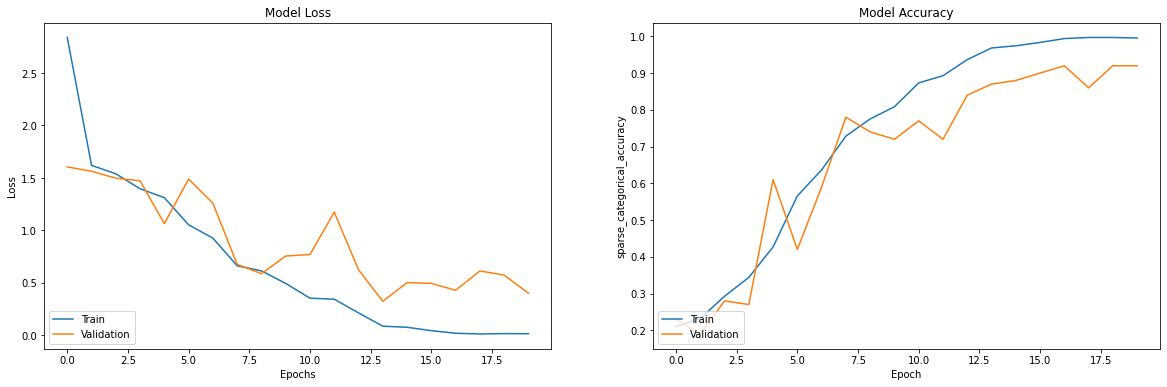

In [13]:
plot_accuracy_loss_graph(history_1) 

**Observation:** 
The graph reveals a machine learning model's performance over epochs, with training and validation data represented for both loss and accuracy. Initially, both training and validation metrics improve rapidly. However, after approximately 10 epochs, the validation loss begins to fluctuate and increase, while validation accuracy plateaus, indicating overfitting. The model is becoming too specialized to the training data and loses its ability to generalize. This is further supported by the consistent gap between training and validation accuracy, which widens as training progresses. To mitigate overfitting, early stopping around epoch 10, regularization techniques, or simplifying the model could be considered.

#### MODEL 2 >>> Conv 3D Model

- Input image size 120X120
- 20 epochs, 20 batch size
- RMSprop optimiser with learning rate 0.0010 with Learning Rate Reduction (lr_factor=0.3, lr_patience=3, min_lr=1e-6)
- Used Batch Normalization, Kernel Regularizer (L2 with 0.001), and Dropouts
- 30/30 frames as input
- Total params: 5,827,461
- Trainable params: 5,826,629
- Non-trainable params: 832

In [ ]:
# High-level overview:
# This code defines and trains a second 3D Convolutional Neural Network (Conv3D) model, model_sample_2, with several enhancements.
# It includes BatchNormalization layers after each Conv3D layer to improve training stability and speed.
# L2 regularization is applied to the Dense layers to prevent overfitting.
# The RMSprop optimizer is used with a specific learning rate.
# The 'before_model_fitting' function is called to set up data generators and callbacks, similar to the first model.
# The model is then compiled and trained using the 'fit' method with the generated data and callbacks.
# The model summary is printed, displaying the architecture and parameters.

model_sample_2 = Sequential([
    # First Conv Block
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(30, 120, 120, 3)),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),

    # Second Conv Block
    Conv3D(64, (3,3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),

    # Third Conv Block
    Conv3D(128, (3,3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2,2,2)),
    Dropout(0.5),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # L2 Regularization
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(5, activation='softmax')
])

optimiser = RMSprop(learning_rate=0.001)
model_sample_2.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_2.summary())
callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting(enable_lr_reduction=True, 
                                                                                                                     lr_factor=0.3, 
                                                                                                                     lr_patience=3, 
                                                                                                                     min_lr=1e-6,
                                                                                                                     enable_early_stopping=False, 
                                                                                                                     es_patience=5, 
                                                                                                                     es_monitor='val_loss', 
                                                                                                                     frames_to_sample=30)

history_2 = model_sample_2.fit(train_generator,
          steps_per_epoch=steps_per_epoch,
          epochs=num_epochs,
          verbose=1,
          callbacks=callbacks_list,
          validation_data=val_generator,
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 28, 118, 118, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 28, 118, 118, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 14, 59, 59, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 12, 57, 57, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 57, 57, 64)   256       
 hNormalization)                                                 
                                                      

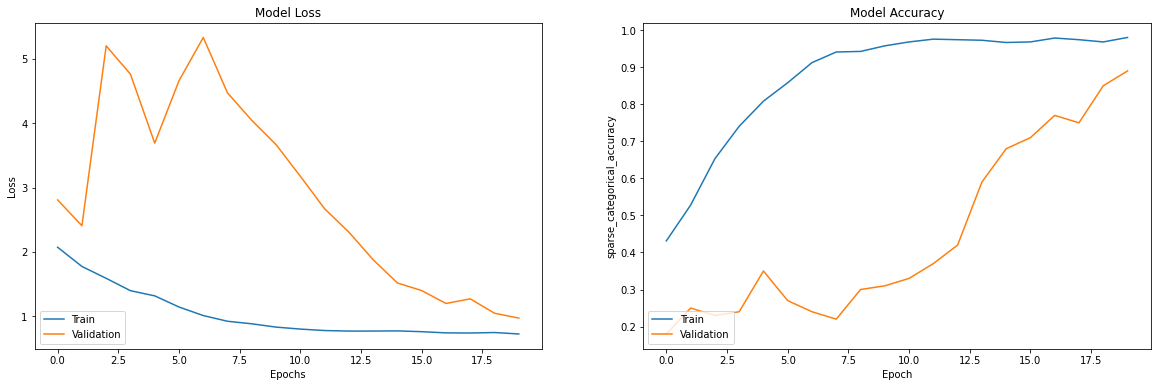

In [ ]:
plot_accuracy_loss_graph(history_2)

**Observation:** The graphs depict a machine learning model's training and validation performance over 20 epochs. On the left, the Model Loss plot shows a steady decrease in training loss (blue line), indicating the model is learning. However, the validation loss (orange line) exhibits significant fluctuations, suggesting instability or overfitting. The Model Accuracy plot on the right further highlights this issue. The training accuracy (blue line) consistently increases, approaching 1.0, while the validation accuracy (orange line) shows a volatile pattern with several sharp drops. This indicates that the model is performing well on the training data but struggling to generalize to unseen data, leading to poor and inconsistent validation performance. The disparity between training and validation metrics suggests potential overfitting, requiring adjustments like regularization, early stopping, or model simplification.


#### MODEL 3 >>> Conv 3D Model

- Input image size 120X120
- 20 epochs, 30 batch size
- Adam optimiser with learning rate 0.0005 with Learning Rate Reduction (lr_factor=0.2, lr_patience=3, min_lr=1e-6)
- Used Kernel Regularizer (L2 with 0.001) and Dropouts
- 27/30 frames as input
- Total params: 38,512,261
- Trainable params: 38,512,261
- Non-trainable params: 0

In [ ]:
# High-level overview:
# This code defines and compiles a third 3D Convolutional Neural Network (Conv3D) model, model_sample_3, with modifications to the architecture and training parameters.
# It adds a fourth Conv3D layer and adjusts dropout rates.
# The Adam optimizer with a learning rate of 0.0005 is used.
# The batch size is changed to 30.
# The 'before_model_fitting' function is called to set up data generators and callbacks, with adjustments to the learning rate reduction factor and the number of frames sampled.
# The model summary is printed to display the architecture and parameters.

model_sample_3 = Sequential([
    
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(30, 120, 120, 3)),
    MaxPooling3D(pool_size=(2,2,2)),

    # Second Conv Block
    Conv3D(64, (3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2)),

    # Third Conv Block
    Conv3D(128, (3,3,3), activation='relu'),
    Dropout(0.3),

    # Fourth Conv Block
    Conv3D(128, (3,3,3), activation='relu'),
    Dropout(0.3),

    # Fully Connected Layers
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(5, activation='softmax')
])

optimiser = Adam(learning_rate=0.0005)
model_sample_3.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_3.summary())
batch_size = 30

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting(enable_lr_reduction=True, 
                                                                                                                     lr_factor=0.2,
                                                                                                                     lr_patience=3,
                                                                                                                     min_lr=1e-6,
                                                                                                                     enable_early_stopping=False,
                                                                                                                     es_patience=5,
                                                                                                                     es_monitor='val_loss',
                                                                                                                     frames_to_sample=27)

history_3 = model_sample_3.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 28, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 14, 59, 59, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 12, 57, 57, 64)    55360     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 6, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 4, 26, 26, 128)    221312    
                                                                 
 dropout_7 (Dropout)         (None, 4, 26, 26, 128)   

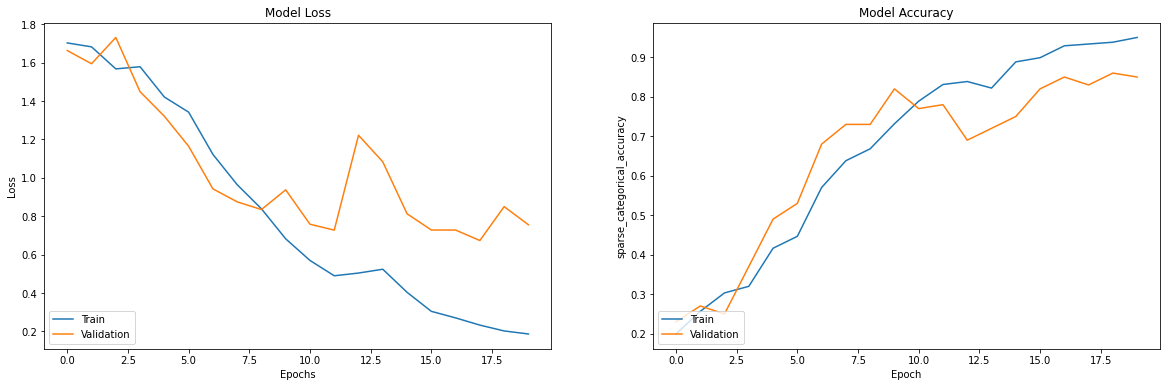

In [ ]:
plot_accuracy_loss_graph(history_3)

**Observation:** The graphs illustrate a machine learning model's training and validation performance over 20 epochs. The Model Loss plot shows decreasing training loss (blue line), indicating learning. However, the fluctuating validation loss (orange line) suggests instability or overfitting. The Model Accuracy plot further highlights this: training accuracy (blue line) steadily increases, while validation accuracy (orange line) demonstrates a volatile pattern with drops. This signifies the model performs well on training data but struggles to generalize, resulting in poor validation performance. This disparity suggests potential overfitting, necessitating adjustments like regularization, early stopping, or model simplification.

#### MODEL 4 >>> Conv 3D Model

- Input image size 120X120
- 30 epochs, 30 batch size
- Adam optimiser with learning rate 0.0005 with Learning Rate Reduction (lr_factor=0.2, lr_patience=3, min_lr=1e-6) and Early Stopping (patience=3, monitor='val_loss')
- Used Kernel Regularizer (L2 with 0.001) and Dropouts
- 27/30 frames as input
- Total params: 38,512,261
- Trainable params: 38,512,261
- Non-trainable params: 0

In [13]:
# High-level overview:
# This code defines and compiles a fourth 3D Convolutional Neural Network (Conv3D) model, model_sample_4.
# Notably, this model's architecture and compilation are identical to model_sample_3.
# This suggests that the code might be a repetition or a test of consistency.
# It uses the Adam optimizer with a learning rate of 0.0005, a batch size of 30, and calls the 'before_model_fitting' function with the same parameters as model_sample_3.
# The model summary is printed, which will be the same as model_sample_3's summary.

model_sample_4 = Sequential([
    
    Conv3D(32, (3, 3, 3), activation='relu', input_shape=(30, 120, 120, 3)),
    MaxPooling3D(pool_size=(2,2,2)),

    # Second Conv Block
    Conv3D(64, (3,3,3), activation='relu'),
    MaxPooling3D(pool_size=(2,2,2)),

    # Third Conv Block
    Conv3D(128, (3,3,3), activation='relu'),
    Dropout(0.3),

    # Fourth Conv Block
    Conv3D(128, (3,3,3), activation='relu'),
    Dropout(0.3),

    # Fully Connected Layers
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(5, activation='softmax')
])

optimiser = Adam(learning_rate=0.0005)
model_sample_4.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_4.summary())
batch_size = 30
num_epochs = 30

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting(enable_lr_reduction=True, 
                                                 lr_factor=0.2, 
                                                 lr_patience=3, 
                                                 min_lr=1e-6, 
                                                 enable_early_stopping=True, 
                                                 es_patience=3, 
                                                 es_monitor='val_loss', 
                                                 frames_to_sample=27)

history_4 = model_sample_4.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 28, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 14, 59, 59, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 12, 57, 57, 64)    55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 4, 26, 26, 128)    221312    
                                                                 
 dropout_5 (Dropout)         (None, 4, 26, 26, 128)   

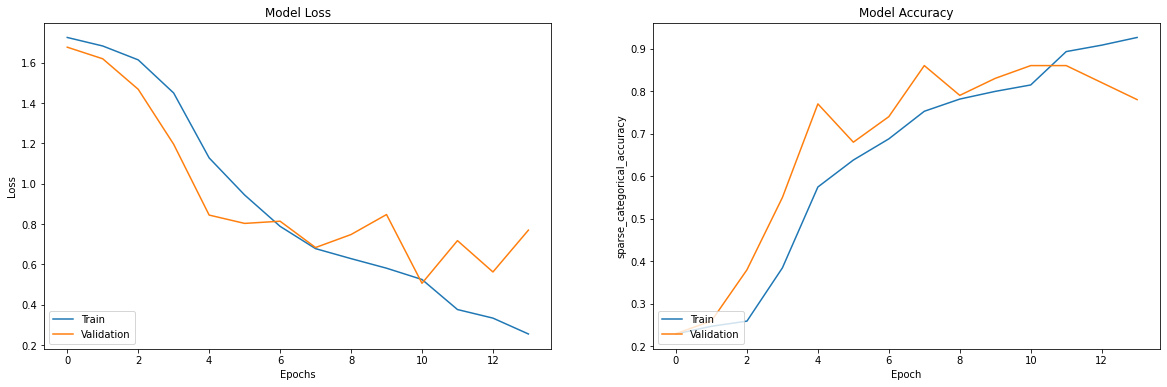

In [16]:
plot_accuracy_loss_graph(history_4)

**Observation:** The provided graphs depict the training and validation performance of a machine learning model over 13 epochs.  The Model Loss plot shows a consistent decrease in training loss (blue line), indicating the model is learning the training data. However, the validation loss (orange line) exhibits fluctuations and a slight increase after epoch 8, suggesting potential overfitting. The Model Accuracy plot shows a steady increase in training accuracy (blue line), nearing 0.9.  The validation accuracy (orange line) also increases, but plateaus and slightly declines after epoch 8, reinforcing the suspicion of overfitting. The divergence between training and validation metrics indicates that while the model learns the training data well, it struggles to generalize to unseen data. This suggests a need for regularization, early stopping, or model simplification to prevent overfitting and improve generalization.

### Exploring with CNN + RNN

For the CNN + RNN models, the generator needs modification because RNNs require sequential feature inputs rather than raw images. We first need to extract spatial features, convert them into feature vectors and then feed them into the RNN to capture temporal dependencies.

We can also try experimenting later with the Transfer Learning (as mentioned in the assignment instructions). We can use a pre-trained CNN model like MobileNet or ResNet to extract features from video frames instead of training a CNN from scratch. This leverages knowledge from a model trained on a large dataset (like ImageNet) to improve performance and reduce training time of our model.

In [17]:
# Modifying the generator a little to suit the CNN + RNN models
# High-level overview:
# This code defines a data generator function, generator2, specifically modified to suit CNN+RNN models.
# It takes a sequence of image indices (img_sequence) as input, which determines the frames to be used for each video sample.
# The generator includes image augmentation capabilities, such as edge enhancement, Gaussian blur, detail enhancement, sharpening, brightness/contrast adjustments, and rotations.
# It also handles image cropping to ensure consistent aspect ratios.
# The generator yields batches of video data and their corresponding labels, shuffling the data at the start of each epoch and optionally duplicating the data if training with augmentation.
# This generator is designed to prepare video data for models that combine convolutional layers for spatial feature extraction and recurrent layers for temporal feature learning.

def generator2(source_path, folder_list, batch_size, img_sequence, x=30, y=120, z=120, is_train=False, augmentation=False):
    """Data generator for CNN + RNN models."""
    
    img_idx = img_sequence
    x=len(img_idx)
    num_batches = len(folder_list) // batch_size  # Number of full batches

    def yield_part(btch_size, folder_subset):
        batch_data = np.zeros((btch_size, x, y, z, 3))  # Video data
        batch_labels = np.zeros((btch_size,), dtype=int)
        
        for folder_idx in range(btch_size):
            video_folder, _, label = folder_subset[folder_idx]  # Unpack tuple/list
            label = int(label)  # Ensure label is an integer
            
            video_path = os.path.join(source_path, video_folder)
            imgs = sorted(os.listdir(video_path))
            
            # Ensure we don't exceed available frames
            max_frames = len(imgs)
            selected_frames = [i for i in img_idx if i < max_frames]  # Only valid indices
            
            for idx, item in enumerate(selected_frames):
                img_path = os.path.join(video_path, imgs[item])
                image = imread(img_path).astype(np.float32) / 255.0  # Normalize
                
                if image.shape[1] > image.shape[0]:
                    diff_px = image.shape[1] - image.shape[0]
                    crop_start = diff_px // 2
                    crop_end = crop_start + image.shape[0]
                    image = image[:, crop_start:crop_end]
                elif image.shape[0] > image.shape[1]:
                    diff_px = image.shape[0] - image.shape[1]
                    crop_start = diff_px // 2
                    crop_end = crop_start + image.shape[1]
                    image = image[crop_start:crop_end, :]
                
                image = resize(image, (y, z))  # Resize
                
                if augmentation:
                    img_pil = Image.fromarray((image * 255).astype(np.uint8), 'RGB')
                    img_pil = img_pil.filter(ImageFilter.EDGE_ENHANCE)
                    img_pil = img_pil.filter(ImageFilter.GaussianBlur(1))
                    img_pil = img_pil.filter(ImageFilter.DETAIL)
                    img_pil = img_pil.filter(ImageFilter.SHARPEN)
                    img_pil = ImageEnhance.Brightness(img_pil).enhance(1.5)
                    img_pil = ImageEnhance.Contrast(img_pil).enhance(1.2)
                    angle = np.random.randint(-10, 10)  
                    img_pil = img_pil.rotate(angle, resample=Image.BICUBIC)
        
                    image = np.array(img_pil) / 255.0  # Convert back to array and normalize
                
                batch_data[folder_idx, idx, :, :, :] = image  # Assign to batch
            
            batch_labels[folder_idx] = label
        
        yield batch_data, batch_labels
    
    while True:
        np.random.shuffle(folder_list)  # Shuffle dataset for each epoch
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
        
        for batch in range(num_batches):
            batch_subset = folder_list[batch * batch_size: (batch + 1) * batch_size]
            yield from yield_part(batch_size, batch_subset)
        
        remaining = len(folder_list) % batch_size  # Handle leftover data
        if remaining > 0:
            batch_subset = folder_list[-remaining:]  # Last few samples
            yield from yield_part(remaining, batch_subset)


The "before_model_fitting" function defined earlier was originally designed to prepare generators, callbacks, and training parameters for a 3D-CNN model, where the generator directly passes raw frames as input.

For a CNN + RNN model, we must modify this function as well to use the MobileNet feature extractor to convert raw frames into feature vectors before passing them to the RNN. This ensures that the model learns temporal relationships from meaningful image features rather than raw pixel data.

In [18]:
# Modifying the before_model_fitting function to adapt to CNN+RNN models
# High-level overview:
# This code defines a modified version of the 'before_model_fitting' function, 'before_model_fitting_2', tailored for CNN+RNN models.
# It takes an 'img_sequence' parameter, which specifies the frame indices to be used by the data generator.
# The function uses the 'generator2' function, which includes image augmentation capabilities if enabled.
# It sets up data generators for training and validation, configures model checkpoints, and optionally adds callbacks for learning rate reduction and early stopping.
# It also calculates the steps per epoch and validation steps based on the dataset size and batch size.
# Essentially, it's a setup routine specifically adapted for CNN+RNN models, handling data loading, callback creation, and step calculations for training.

def before_model_fitting_2(img_sequence, enable_lr_reduction=False, lr_factor=0.5, lr_patience=3, min_lr=1e-6, 
                         enable_early_stopping=False, es_patience=5, es_monitor='val_loss', enable_augmentation=False):
  
    train_folder_list = train_doc.tolist()
    val_folder_list = val_doc.tolist()

    train_generator = generator2(train_path, train_folder_list, batch_size, img_sequence, is_train=True, augmentation = enable_augmentation)
    val_generator = generator2(val_path, val_folder_list, batch_size, img_sequence)

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto'
                                 #save_freq='epoch'
                                )

    # Initialize callbacks list
    callbacks_list = [checkpoint]

    # Add ReduceLROnPlateau if enabled
    if enable_lr_reduction:
        LR = ReduceLROnPlateau(monitor='val_loss', 
                               factor=lr_factor, 
                               patience=lr_patience, 
                               verbose=1, 
                               min_lr=min_lr)
        callbacks_list.append(LR)

    # Add EarlyStopping if enabled
    if enable_early_stopping:
        early_stopping = EarlyStopping(monitor=es_monitor, 
                                       patience=es_patience, 
                                       restore_best_weights=True, 
                                       verbose=1)
        callbacks_list.append(early_stopping)

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint



#### MODEL 5 >>> TimeDistributed Conv2D + GRU Model

- Input image size 120X120
- 30 epochs, 20 batch size
- RMSprop optimiser with learning rate 0.0001 with Learning Rate Reduction (lr_factor=0.5, lr_patience=3, min_lr=1e-6)
- Used Batch Normalization
- 11/30 frames as input
- Total params: 99,845
- Trainable params: 99,269
- Non-trainable params: 576

In [19]:
# High-level overview:
# This code defines and compiles a CNN+RNN model (model_sample_5) for video classification.
# It uses TimeDistributed layers to apply 2D convolutional operations to each frame of the video sequence.
# The model includes Conv2D, MaxPooling2D, GlobalAveragePooling2D, and Dense layers, followed by a GRU layer to process the temporal sequence.
# BatchNormalization is used to improve training stability.
# The RMSprop optimizer with a learning rate of 0.0001 is used.
# The 'before_model_fitting_2' function is called to set up data generators and callbacks, with a specific image sequence (range(6, 27, 2)) and augmentation disabled.
# The model summary is printed to display the architecture and parameters.
# The input shape is (11, 120, 120, 3), indicating 11 time steps (frames) of 120x120 RGB images.

input_shape = (11, 120, 120, 3)  # (time_steps, height, width, channels)

model_sample_5 = Sequential([
    
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2,2))),
    BatchNormalization(),
    
    TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2,2))),
    BatchNormalization(),
    
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(64, activation='relu')),
    BatchNormalization(),
    
    GRU(128),
    BatchNormalization(),
    Dense(5, activation='softmax')
])


# Optimizer & Compilation
optimiser = RMSprop(learning_rate=0.0001)
model_sample_5.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_5.summary())

batch_size = 20

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting_2(
    img_sequence = range(6,27,2),
    enable_lr_reduction=True, 
    lr_factor=0.5, 
    lr_patience=3, 
    min_lr=1e-6,
    enable_early_stopping=False,
    es_patience=5,
    es_monitor='val_loss',
    enable_augmentation= False
)

history_5 = model_sample_5.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 11, 120, 120, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 11, 60, 60, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 11, 60, 60, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_8 (TimeDis  (None, 11, 60, 60, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 11, 30, 30, 64)  

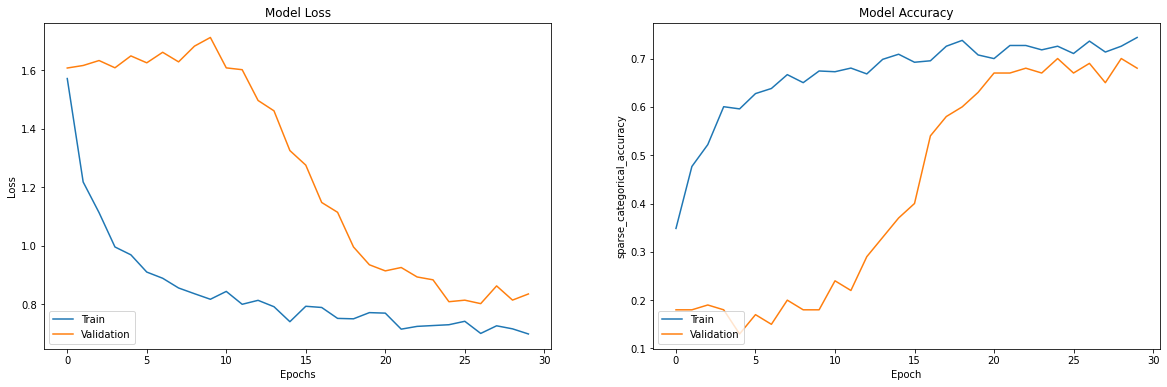

In [ ]:
plot_accuracy_loss_graph(history_5)

**Observation:** This set of graphs depicts the training and validation performance of a machine learning model over 30 epochs. The Model Loss plot shows a consistent decrease in training loss (blue line), indicating effective learning on the training data. However, the validation loss (orange line) fluctuates and plateaus after around epoch 10, suggesting potential overfitting or lack of further generalization. The Model Accuracy plot reinforces this observation. The training accuracy (blue line) steadily increases and reaches a plateau around 0.7. In contrast, the validation accuracy (orange line) initially rises but plateaus and even shows a slight decrease after epoch 20. This divergence between training and validation metrics, particularly the plateauing and potential decline in validation accuracy, suggests that the model is overfitting to the training data. To improve generalization, techniques such as early stopping, regularization, or adjusting the model's complexity should be considered.

#### MODEL 6 >>> TimeDistributed Conv2D + ConvLSTM2D + LSTM Model

- Input image size 120X120
- 30 epochs, 32 batch size
- Adam optimiser with learning rate 0.0001 with Learning Rate Reduction (lr_factor=0.5, lr_patience=3, min_lr=1e-6)
- Used Dropouts
- 10/30 frames as input
- Total params: 1,289,157
- Trainable params: 1,289,157
- Non-trainable params: 0

In [ ]:
# High-level overview:
# This code defines and trains a complex CNN+RNN model (model_sample_6) for video classification, incorporating ConvLSTM2D layers for spatiotemporal feature learning.
# It starts with a TimeDistributed Conv2D layer for initial feature extraction, followed by multiple ConvLSTM2D layers to capture both spatial and temporal dependencies.
# Dropout layers are added throughout the model to prevent overfitting.
# The model includes TimeDistributed GlobalAveragePooling2D and Dense layers, and a final LSTM layer to process the temporal sequence.
# The Adam optimizer with a learning rate of 0.0001 is used.
# The 'before_model_fitting_2' function is called to set up data generators and callbacks, with a specific image sequence (range(7, 26, 2)) and augmentation enabled.
# The model is trained using the 'fit' method with the generated data and callbacks.
# The model summary is printed to display the architecture and parameters.
# The input shape is (10, 120, 120, 3), indicating 10 time steps (frames) of 120x120 RGB images.

input_shape = (10, 120, 120, 3)  # (time_steps, height, width, channels)

model_sample_6 = Sequential([
    
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    ConvLSTM2D(32, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    ConvLSTM2D(64, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    ConvLSTM2D(128, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(64, activation='relu')),
    Dropout(0.25),
    
    LSTM(128),
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])


# Optimizer & Compilation
optimiser = Adam(learning_rate=0.0001)
model_sample_6.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_6.summary())

batch_size = 32

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting_2(
    img_sequence = range(7,26,2),
    enable_lr_reduction=True, 
    lr_factor=0.5, 
    lr_patience=3, 
    min_lr=1e-6,
    enable_early_stopping=False,
    es_patience=5,
    es_monitor='val_loss',
    enable_augmentation= True
)

history_6 = model_sample_6.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 dropout_10 (Dropout)        (None, 10, 60, 60, 32)    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 60, 60, 32)    73856     
                                                                 
 time_distributed_14 (TimeDi  (None, 10, 30, 30, 32)   0         
 stributed)                                                      
                                                      

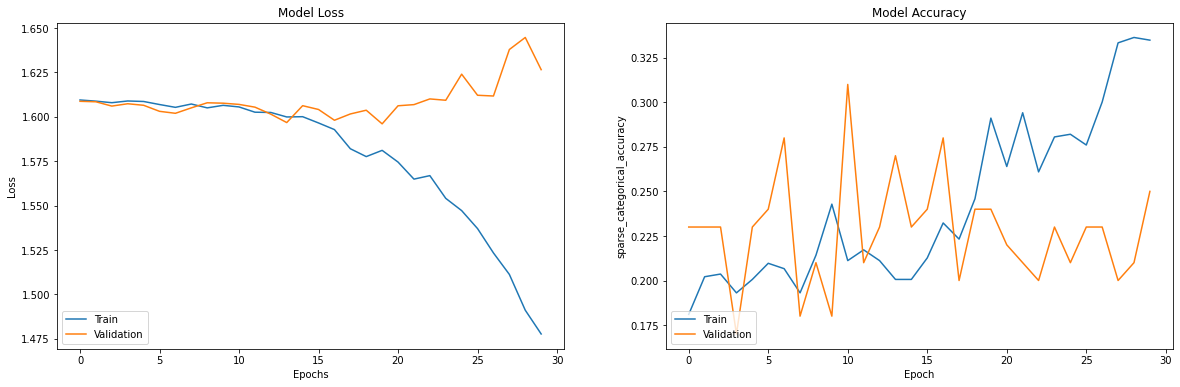

In [ ]:
plot_accuracy_loss_graph(history_6)

**Observation:** This graph depicts the training and validation performance of a model over 30 epochs. The Model Loss plot shows a gradual decrease in training loss (blue line), indicating the model is learning. However, the validation loss (orange line) initially follows a similar trend but then begins to fluctuate and increase after epoch 20, suggesting potential overfitting. The Model Accuracy plot further illustrates this issue. While the training accuracy (blue line) shows a slight upward trend, the validation accuracy (orange line) exhibits significant fluctuations and remains relatively low throughout the training process. The large gap and instability in validation metrics indicate that the model is struggling to generalize to unseen data. This suggests a need for adjustments such as regularization, early stopping, or a simpler model architecture to improve performance and prevent overfitting.


#### MODEL 7 >>> TimeDistributed Conv2D + ConvLSTM2D + Multi-Layer LSTM Model

- Input image size 120X120
- 50 epochs, 48 batch size
- Adam optimiser with learning rate 0.0005 with Learning Rate Reduction (lr_factor=0.2, lr_patience=3, min_lr=1e-6)
- Used Dropouts
- 11/30 frames as input
- Total params: 1,371,269
- Trainable params: 1,371,269
- Non-trainable params: 0

In [24]:
# High-level overview:
# This code defines and trains a more complex CNN+RNN model (model_sample_7) for video classification, with a deeper architecture.
# It starts with TimeDistributed Conv2D and MaxPooling2D layers, followed by multiple ConvLSTM2D layers to capture spatiotemporal features.
# Dropout layers are added to prevent overfitting.
# The model includes TimeDistributed GlobalAveragePooling2D and Dense layers.
# It incorporates a stacked LSTM structure with three LSTM layers, adding increased temporal processing capacity.
# The Adam optimizer with a learning rate of 0.0005 is used.
# The 'before_model_fitting_2' function is called to set up data generators and callbacks, with a specific image sequence (range(6, 27, 2)) and augmentation disabled.
# The model is trained using the 'fit' method with the generated data and callbacks.
# The model summary is printed to display the architecture and parameters.
# The input shape is (11, 120, 120, 3), indicating 11 time steps (frames) of 120x120 RGB images.
# The batch size is increased to 48, and the number of epochs is set to 50.

input_shape = (11, 120, 120, 3)  # (time_steps, height, width, channels)

model_sample_7 = Sequential([
    
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2,2))),
    
    ConvLSTM2D(32, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    
    ConvLSTM2D(64, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    ConvLSTM2D(128, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(64, activation='relu')),
    Dropout(0.25),
    
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
    
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])


# Optimizer & Compilation
optimiser = Adam(learning_rate=0.0005)
model_sample_7.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_7.summary())

batch_size = 48
num_epochs = 50

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting_2(
    img_sequence = range(6,27,2),
    enable_lr_reduction=True, 
    lr_factor=0.2, 
    lr_patience=3, 
    min_lr=1e-6,
    enable_early_stopping=False,
    es_patience=5,
    es_monitor='val_loss',
    enable_augmentation= False
)

history_7 = model_sample_7.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_19 (TimeDi  (None, 11, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 11, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 11, 60, 60, 32)    73856     
                                                                 
 time_distributed_21 (TimeDi  (None, 11, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 11, 30, 30, 64)    221440    
                                                      

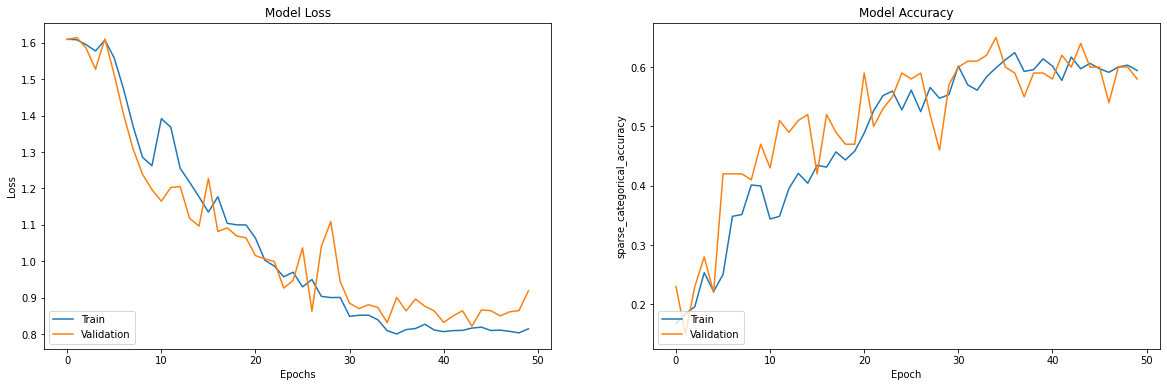

In [ ]:
plot_accuracy_loss_graph(history_7)

**Observation:** The provided graphs depict the training and validation performance of a model over 50 epochs. The Model Loss plot shows a rapid decrease in training loss (blue line) in the initial epochs, indicating the model is learning effectively. The validation loss (orange line) follows a similar trend, but with some fluctuations, and plateaus after around epoch 20, suggesting potential overfitting or limited further learning. The Model Accuracy plot shows a steady increase in both training and validation accuracy, with both lines converging around 0.6. However, the validation accuracy plateaus after epoch 30, while the training accuracy continues to show slight improvement. This suggests that while the model is learning, it might be reaching a point where it is memorizing the training data rather than generalizing well. The plateauing of validation metrics indicates that further training may not lead to significant improvements, and adjustments like early stopping or regularization might be necessary.

#### MODEL 8 >>> TimeDistributed Conv2D + ConvLSTM2D + Deeper Multi-Layer LSTM Model

- Input image size 120X120
- 50 epochs, 48 batch size
- Adam optimiser with learning rate 0.0001 with Learning Rate Reduction (lr_factor=0.2, lr_patience=3, min_lr=1e-8)
- Used TimeDistributed Conv2D, MaxPooling2D, ConvLSTM2D, Deeper Multi-Layer LSTM, GlobalAveragePooling2D, and Dropouts
- 11 frames as input
- Total params: 1,383,525
- Trainable params: 1,383,525
- Non-trainable params: 0

In [ ]:
# High-level overview:
# This code defines and trains a very deep CNN+RNN model (model_sample_8) for video classification, featuring an extensive recurrent architecture.
# It starts with TimeDistributed Conv2D and MaxPooling2D layers for initial feature extraction, followed by multiple ConvLSTM2D layers to capture spatiotemporal dependencies.
# Dropout layers are included to prevent overfitting.
# The model incorporates TimeDistributed GlobalAveragePooling2D and Dense layers.
# It uses a stacked LSTM structure with four LSTM layers, increasing the model's ability to learn complex temporal patterns.
# The Adam optimizer with a learning rate of 0.0001 is used.
# The 'before_model_fitting_2' function is called to set up data generators and callbacks, with a specific image sequence (range(6, 27, 2)) and augmentation disabled.
# The model is trained using the 'fit' method with the generated data and callbacks.
# The model summary is printed to display the architecture and parameters.
# The input shape is (11, 120, 120, 3), indicating 11 time steps (frames) of 120x120 RGB images.
# The batch size is 48, the number of epochs is 50, and the minimum learning rate for learning rate reduction is set to 1e-8.

input_shape = (11, 120, 120, 3)  # (time_steps, height, width, channels)

model_sample_8 = Sequential([
    
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2,2))),
    
    ConvLSTM2D(32, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    
    ConvLSTM2D(64, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    ConvLSTM2D(128, (3,3), activation='relu', padding='same', return_sequences = True),
    TimeDistributed(MaxPooling2D((2,2))),
    Dropout(0.25),
    
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(64, activation='relu')),
    Dropout(0.25),
    
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    
    Dropout(0.25),
    
    Dense(5, activation='softmax')
])


# Optimizer & Compilation
optimiser = Adam(learning_rate=0.0001)
model_sample_8.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_8.summary())

batch_size = 48
num_epochs = 50

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting_2(
    img_sequence = range(6,27,2),
    enable_lr_reduction=True, 
    lr_factor=0.2, 
    lr_patience=3, 
    min_lr=1e-8,
    enable_early_stopping=False,
    enable_augmentation= False
)

history_8 = model_sample_8.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 11, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 11, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 11, 60, 60, 32)    73856     
                                                                 
 time_distributed_28 (TimeDi  (None, 11, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 11, 30, 30, 64)    221440    
                                                      

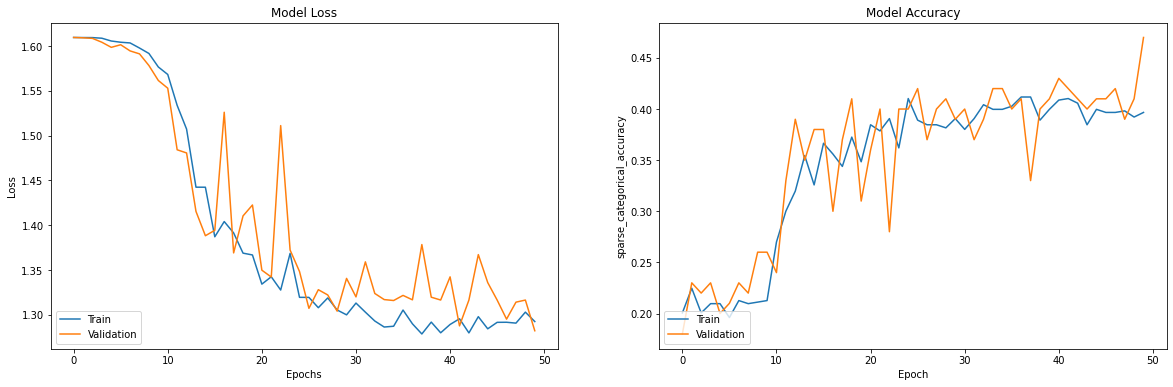

In [ ]:
plot_accuracy_loss_graph(history_8)

**Observaion:** The graphs depict a machine learning model's performance over 50 epochs. The Model Loss plot shows a rapid initial decrease in training loss (blue line), indicating quick learning. However, the validation loss (orange line) fluctuates significantly, especially after epoch 20, suggesting instability or potential overfitting. The Model Accuracy plot shows a similar trend. Both training and validation accuracy increase initially, but the validation accuracy exhibits substantial fluctuations and plateaus around 0.4, while the training accuracy shows a slight upward trend. The instability and low plateau in validation metrics indicate that the model is struggling to generalize to unseen data. This suggests a need for adjustments like regularization, early stopping, or a simpler model architecture to improve performance and prevent overfitting. The significant fluctuations in validation metrics also suggest potential issues with the data or training process.

#### MODEL 9 >>> TimeDistributed Conv2D + Multi-Layer GRU Model

- Input image size 120X120
- 50 epochs, 28 batch size
- RMSprop optimiser with learning rate 0.0001 with Learning Rate Reduction (lr_factor=0.5, lr_patience=3, min_lr=1e-5)
- Used TimeDistributed Conv2D, MaxPooling2D, GlobalAveragePooling2D, Multi-Layer GRU, and Dropouts
- 11 frames as input
- Total params: 246,405
- Trainable params: 246,405
- Non-trainable params: 0

In [ ]:
# High-level overview:
# This code defines and trains a CNN+GRU model (model_sample_9) for video classification.
# It starts with TimeDistributed Conv2D and MaxPooling2D layers for spatial feature extraction, followed by TimeDistributed GlobalAveragePooling2D and Dense layers.
# The model incorporates two GRU layers to capture temporal dependencies, with the first GRU layer returning sequences to feed into the second.
# Dropout is added to prevent overfitting.
# The RMSprop optimizer with a learning rate of 0.0001 is used.
# The 'before_model_fitting_2' function is called to set up data generators and callbacks, with a specific image sequence (range(6, 27, 2)) and augmentation disabled.
# The model is trained using the 'fit' method with the generated data and callbacks.
# The model summary is printed to display the architecture and parameters.
# The input shape is (11, 120, 120, 3), indicating 11 time steps (frames) of 120x120 RGB images.
# The batch size is 28, the number of epochs is 50, and the minimum learning rate for learning rate reduction is set to 1e-5.

input_shape = (11, 120, 120, 3)  # (time_steps, height, width, channels)

model_sample_9 = Sequential([

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=input_shape),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dense(128, activation='relu')),

    # Ensuring GRU receives 3D input (batch_size, time_steps, features)
    GRU(128, return_sequences=True),  
    GRU(64),

    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Optimizer & Compilation
optimiser = RMSprop(learning_rate=0.0001)
model_sample_9.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

print(model_sample_9.summary())

batch_size = 28
num_epochs = 50

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting_2(
    img_sequence = range(6,27,2),
    enable_lr_reduction=True, 
    lr_factor=0.5, 
    lr_patience=3, 
    min_lr=1e-5,
    enable_early_stopping=False,
    enable_augmentation= False
)

history_9 = model_sample_9.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
#           workers=1,
          initial_epoch=0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 11, 120, 120, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 11, 60, 60, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 11, 60, 60, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 11, 30, 30, 64)   0         
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 11, 30, 30, 128) 

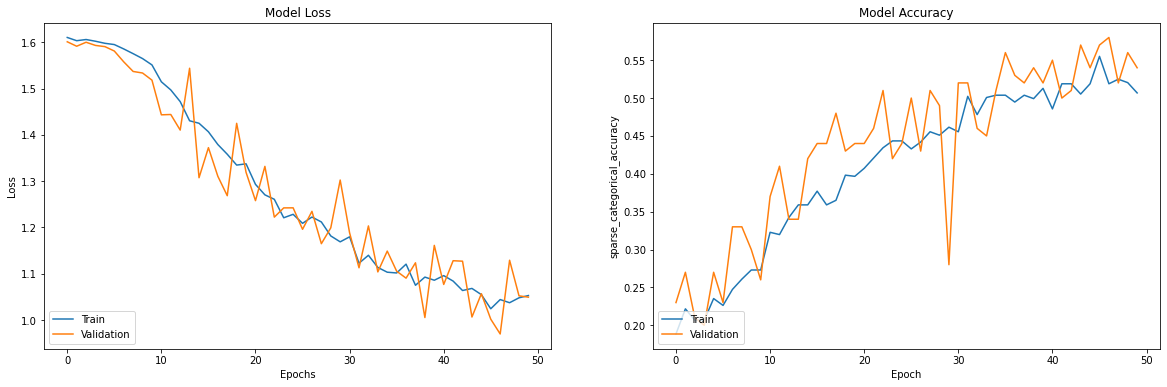

In [ ]:
plot_accuracy_loss_graph(history_9)

**Observations:** The provided graphs depict a machine learning model's performance over 50 epochs. The Model Loss plot shows a consistent decrease in both training (blue line) and validation (orange line) loss, indicating the model is learning. However, there are fluctuations in the validation loss, suggesting potential instability or areas where the model struggles to generalize. The Model Accuracy plot shows a steady increase in both training and validation accuracy up to around epoch 40, where they both plateau. The validation accuracy exhibits more fluctuations than the training accuracy, indicating that the model's performance on unseen data is less consistent. The plateauing of accuracy suggests that the model may have reached its learning capacity or is overfitting, and further training may not result in significant improvements. Adjustments like early stopping or regularization might be necessary to address these issues.

In [32]:
# High-level overview:
# This code defines a data generator function, generatorMobileNet, designed to prepare video data for models that utilize MobileNet or similar architectures.
# It takes a sequence of frame indices (frame_seq) as input, which determines the frames to be used for each video sample.
# The generator reads video data from a specified source, preprocesses it by resizing and normalizing frames, and then yields batches of video data and their corresponding labels.
# It handles batching, shuffling, and ensures that frame indices are valid.
# This generator is specifically tailored for models that require a sequence of frames as input, making it suitable for temporal processing with MobileNet-based architectures.

def generatorMobileNet(source_path, folder_list, batch_size, frame_seq):
    img_idx = frame_seq  
    x = len(frame_seq)
    y, z = 120, 120
    num_batches = len(folder_list) // batch_size  # Number of full batches

    def yield_part(btch_size, folder_subset):
        batch_data = np.zeros((btch_size, x, y, z, 3))  # Video data
        batch_labels = np.zeros((btch_size,), dtype=int)

        for folder_idx in range(btch_size):
            video_folder, _, label = folder_subset[folder_idx]  # Unpack tuple/list
            label = int(label)  # Ensure label is an integer

            video_path = os.path.join(source_path, video_folder)
            imgs = sorted(os.listdir(video_path))

            # Ensure we don't exceed available frames
            max_frames = len(imgs)
            selected_frames = [i for i in img_idx if i < max_frames]  # Only valid indices

            for idx, item in enumerate(selected_frames):
                img_path = os.path.join(video_path, imgs[item])
                image = imread(img_path).astype(np.float32) / 255.0  # Normalize
                image = resize(image, (y, z))  # Resize

                batch_data[folder_idx, idx, :, :, :] = image  # Assign to batch

            batch_labels[folder_idx] = label

        yield batch_data, batch_labels

    while True:
        np.random.shuffle(folder_list)  # Shuffle dataset for each epoch

        for batch in range(num_batches):
            batch_subset = folder_list[batch * batch_size : (batch + 1) * batch_size]
            yield from yield_part(batch_size, batch_subset)

        remaining = len(folder_list) % batch_size  # Handle leftover data
        if remaining > 0:
            batch_subset = folder_list[-remaining:]  # Last few samples
            yield from yield_part(remaining, batch_subset)

In [33]:
# Modifying the before_model_fitting function to adapt to CNN+RNN models

# High-level overview:
# This code defines a modified version of the 'before_model_fitting' function, 'before_model_fitting_3', specifically tailored for models using the 'generatorMobileNet' data generator.
# It takes an 'img_sequence' parameter, which specifies the frame indices to be used by the data generator.
# The function uses the 'generatorMobileNet' function to create data generators for training and validation.
# It configures model checkpoints and optionally adds callbacks for learning rate reduction and early stopping.
# It calculates the steps per epoch and validation steps based on the dataset size and a fixed batch size of 32.
# Essentially, it's a setup routine adapted for models using the 'generatorMobileNet' data generator, handling data loading, callback creation, and step calculations for training.

def before_model_fitting_3(img_sequence, enable_lr_reduction=False, lr_factor=0.5, lr_patience=3, min_lr=1e-6, enable_early_stopping=False, es_patience=5):
  
    train_folder_list = train_doc.tolist()
    val_folder_list = val_doc.tolist()

    train_generator = generatorMobileNet(source_path=train_path, 
                                 folder_list=train_folder_list, 
                                 batch_size=32, 
                                 frame_seq=img_sequence)  
    
    val_generator = generatorMobileNet(source_path=val_path, 
                               folder_list=val_folder_list,
                               batch_size=32, 
                               frame_seq=img_sequence) 

    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto'
                                 #save_freq='epoch'
                                )

    # Initialize callbacks list
    callbacks_list = [checkpoint]

    # Add ReduceLROnPlateau if enabled
    if enable_lr_reduction:
        LR = ReduceLROnPlateau(monitor='val_loss', 
                               factor=lr_factor, 
                               patience=lr_patience, 
                               verbose=1, 
                               min_lr=min_lr)
        callbacks_list.append(LR)
        
    # Add EarlyStopping if enabled
    if enable_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=es_patience,
                                       restore_best_weights=True,
                                       verbose=1)
        callbacks_list.append(early_stopping)
        
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint


#### MODEL 10 >>> TimeDistributed MobileNet + GRU Model

- Input image size 120X120
- 20 epochs, (batch size is determined by train_generator, please provide if known)
- Adam optimiser with Learning Rate Reduction (lr_factor=0.5, lr_patience=3, min_lr=1e-4)
- Used TimeDistributed MobileNet, Batch Normalization, MaxPooling2D, GRU, Kernel Regularizer (L2 with 0.05), and Dropouts
- 11 frames as input
- Total params: 3,264,095
- Trainable params: 3,240,159
- Non-trainable params: 23,936

In [36]:
# High-level overview:
# This code defines and trains a CNN+GRU model (mobileNetModelWeight) using MobileNet as a feature extractor for video classification.
# It loads the pre-trained MobileNet model (without the top layers) and applies it to each frame of the video sequence using TimeDistributed.
# BatchNormalization and MaxPooling2D are applied to the MobileNet output, followed by Dropout and Flatten layers.
# A GRU layer is used to process the temporal sequence, and a final Dense layer with softmax activation is used for classification.
# The Adam optimizer is used, and the model is compiled with sparse categorical crossentropy loss and sparse categorical accuracy metrics.
# The 'before_model_fitting_3' function is called to set up data generators and callbacks, with a specific image sequence (range(6, 27, 2)).
# The model is trained using the 'fit' method with the generated data and callbacks.
# The model summary is printed to display the architecture and parameters.
# The input shape is (11, 120, 120, 3), indicating 11 time steps (frames) of 120x120 RGB images.
# The batch size is 32, the number of epochs is 20, and learning rate reduction is enabled with a minimum learning rate of 1e-4.

num_epochs = 20
batch_size = 32

mobilenet_transfer = MobileNet(weights='imagenet', include_top=False)

input_shape = (11, 120, 120, 3)

mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer, input_shape=(input_shape)))
mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(Dropout(0.5))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(10, kernel_regularizer=l2(0.05), dropout=0.5, recurrent_dropout=0.2))
mobileNetModelWeight.add(Dropout(0.5))

mobileNetModelWeight.add(Dense(5, activation='softmax'))

optimiser = Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(mobileNetModelWeight.summary())

callbacks_list, steps_per_epoch, validation_steps, train_generator, val_generator, checkpoint = before_model_fitting_3(img_sequence = range(6,27,2), 
                                                                                                                       enable_lr_reduction=True, 
                                                                                                                       lr_factor=0.5, 
                                                                                                                       lr_patience=3, 
                                                                                                                       min_lr=1e-4,
                                                                                                                       enable_early_stopping=False)


history_10 = mobileNetModelWeight.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list,
          validation_data=val_generator, 
          validation_steps=validation_steps,
          class_weight=None,
          workers=1,
          initial_epoch=0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_49 (TimeDi  (None, 11, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 11, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_51 (TimeDi  (None, 11, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 dropout_29 (Dropout)        (None, 11, 1, 1, 1024)    0         
                                                                 
 time_distributed_52 (TimeDi  (None, 11, 1024)         0         
 stributed)                                          

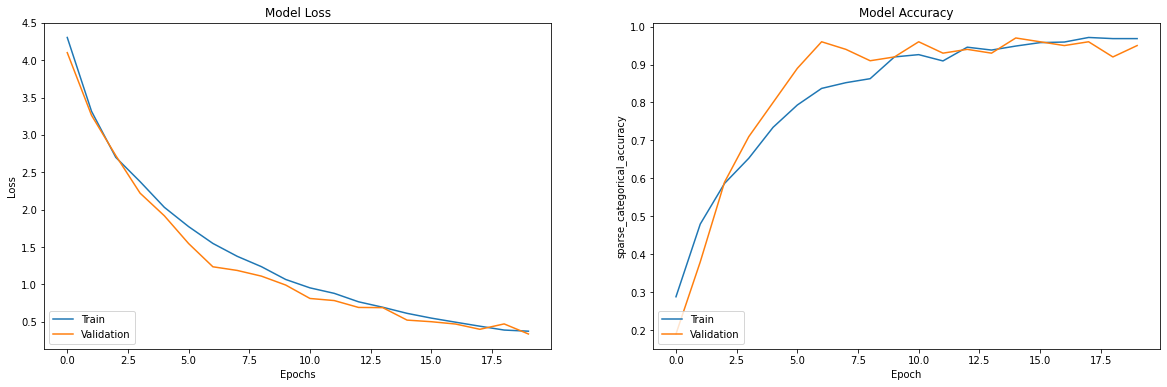

In [ ]:
plot_accuracy_loss_graph(history_10)

**Observation:** The graphs illustrate the training and validation performance of a model over 20 epochs. The Model Loss plot shows a consistent decrease in both training and validation loss, indicating effective learning. Notably, the validation loss closely follows the training loss, suggesting good generalization. The Model Accuracy plot reinforces this observation. Both training and validation accuracy increase steadily, converging around 0.95. The close alignment of training and validation metrics suggests that the model is learning well and generalizing effectively, with minimal signs of overfitting. The consistent improvement in both loss and accuracy implies that the model is well-suited for the task and training parameters are appropriate.